In [19]:
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
import json
import os
import pandas as pd

In [42]:
def list_dir(dir_path):
    """
    Get all 'lambda_info' prefix files from a directory path.
    @param dir_path: Path of the directory.
    @return: A list of file paths with the prefix, 'lambda_info'.
    """
    files = []

    for f in os.listdir(dir_path):
        if(f.startswith('lambda_info')):
            files.append(os.path.join(dir_path, f))
    
    sorted(files, key=lambda x: x.split('_')[5])
    
    return files
    
    
def parse_filename(filename):
    """
    Extract memory size and cell number info from the filename.
    @param filename: A file name.
    @return: The corresponding memory size and cell number of the file.
    """
    splt = filename.split('_')
    mem = int(splt[3])
    cells = int(splt[5])
    return dict(
        memory=mem,
        cells=cells
    )


def get_durations_status(js):
    """
    Get each lambda invocation's duration and its status.
    @param js: A dict which contains all lambda invocations data.
    @return: A list of lambda invocation duration and status pair.
    """
    results = []
    
    for lambda_info in js['info']:
        results.append((lambda_info['duration_ms'], lambda_info['status']))
    
    return results


def get_experiments(files):
    """
    Get lambda performance metrics data from a list of files.
    @param files: List of file paths.
    @return: A list of performance metrics data in that file.
    """
    experiments = []

    for f in files:
        with open(f, 'r') as fh:
            exp = parse_filename(f)
            js = json.load(fh)
            exp['durations_status'] = get_durations_status(js)
            exp['median'] = np.median([i[0] for i in exp['durations_status']])
            experiments += [exp]
    
    return experiments

In [40]:
def filter_errors(durations_status):
    """
    Catergorize a list of durations_status pairs.
    @param durations_status: A list of lambda invocation duration and status pair.
    @return: Duration and status pairs for lambda invocation w/o errors.
    """
    durations_without_error = []
    durations_with_timeout = []
    durations_with_error = []
    
    for duration_status in durations_status:
        if duration_status[1] is None:
            durations_without_error.append(duration_status[0])
        elif duration_status[1] == 'timeout':
            durations_with_timeout.append(duration_status[0])
        elif duration_status[1] == 'error':
            durations_with_error.append(duration_status[0])
    
    return durations_without_error, durations_with_timeout, durations_with_error


def plot_memory(experiments, memory, memory_colors, plt, label):
    """
    Plot experiments data for a particular lambda memory size.
    @param experiments: All experiments data.
    @param memory: Lambda function memory size.
    @param memory_colors: A dict storing corresponding plot color for each memory size.
    @param plt: The plot.
    @param label: Label for the data points in the plot.
    """
    exps = sorted([exp for exp in experiments if exp['memory'] == memory], key=lambda d: d['cells'])
    xs = [float(exp['cells']) for exp in exps]
    ys = [exp['median'] for exp in exps]
    
    plt.plot(xs, ys, label=label, color=memory_colors[memory])
    
    for exp in exps:
        durations_without_error, durations_with_timeout, durations_with_error = \
            filter_errors(exp['durations_status'])
        plt.scatter([exp['cells']]*len(durations_without_error), durations_without_error, 
                    color=memory_colors[memory], alpha=0.2)
        plt.scatter([exp['cells']]*len(durations_with_timeout), durations_with_timeout, 
                    color=memory_colors[memory], marker='x', alpha=0.5)
        plt.scatter([exp['cells']]*len(durations_with_error), durations_with_error, 
                    color=memory_colors[memory], marker='P', alpha=0.5)
        

def plot_memories(experiments):
    """
    Plot experiments data for all lambda memory sizes.
    @param experiments: All experiments data.
    """
    memories = sorted(list(set([exp['memory'] for exp in experiments])))
    memory_colors = dict([(count, 'C' + str(num+1)) for num, count in enumerate(memories)])

    plt.figure(figsize=(12,10))
    
    for memory in memories:
        label = 'memory=' + str(memory) + "MB"
        plot_memory(experiments, memory, memory_colors, plt, label)

    plt.legend(loc='best')
    plt.xlim([0, 512])
    plt.ylim([0, 350000])
    plt.title('median time to job completion')
    plt.xlabel('Cells')
    plt.ylabel('Duration (ms)')
    plt.show()

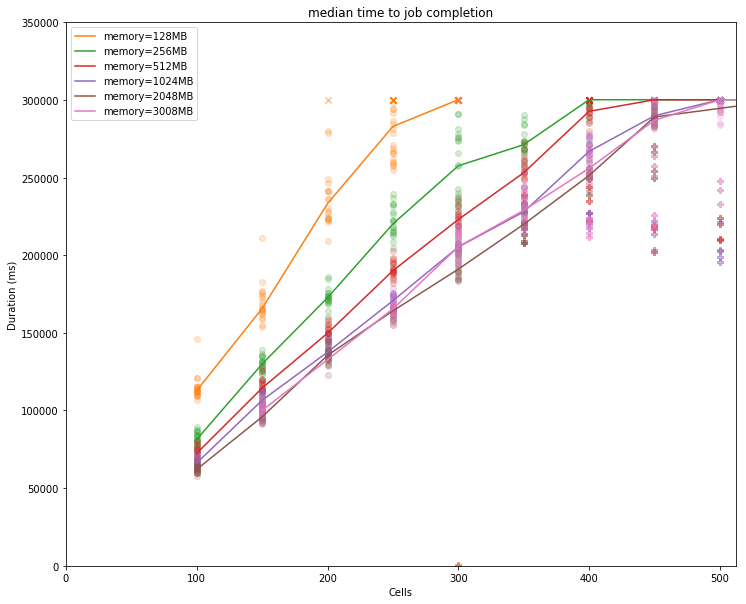

In [41]:
files_v0 = list_dir('../data/v1.0.0')
experiments_v0 = get_experiments(files_v0)
plot_memories(experiments_v0)

In [43]:
def plot_compare(experiments_a, experiments_b, label_a, label_b, lambda_memory):
    """
    Visualize the data points in a plot to compare two different experiments with the same
    lambda function memory size.
    """
    plt.figure(figsize=(12,10))
    plot_memory(experiments_a, lambda_memory, {lambda_memory: "C1"}, plt, label_a)
    plot_memory(experiments_b, lambda_memory, {lambda_memory: "C2"}, plt, label_b)

    plt.legend(loc='best')
    plt.xlim([0, 512])
    plt.ylim([0, 350000])
    plt.title('median time to job completion on {}MB lambda'.format(lambda_memory))
    plt.xlabel('Cells')
    plt.ylabel('Duration (ms)')
    plt.show()

# Report

### Errors

1. 
```
OSError: [Errno 28] No space left on device
```
2. 
```
Task timed out after *** seconds
```

### Findings
Q. Under the same lambda configuration and same number of cells for concatenation, why some lambda invocations cause `No space left on device` error, but some do not?  

To improve performance, AWS Lambda may choose to retain an instance of your function and reuse it to serve a subsequent request, rather than creating a new copy.

Q. When a lambda performs matrices concatenation at its upper limit, why most of errors occuring are `Errno 28` instead of `Task timed out`?

For performance reasons, AWS Lambda might retain and reuse instances of your function on subsequent calls. Under the situation when lambda exits normally, all downloaded matrix files will be removed after concatenating. However, when a lambda abnormally exits due to timeout before concatenating those downloaded matrices, those garbage files will not be removed. As a result, when next lambda call comes and it reuse the previous instances full of garbage files, the disk space available for it to use is already full.

Solution: Clear tmp/ directory at the beginning of each lambda.
 